In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Data Prep

In [342]:
weather_df = pd.read_csv('1498696.csv')

In [345]:
weather_df.DATE[0]
weather_df['ts'] = [pd.to_datetime(weather_df['DATE'][ik]) for ik in range(len(weather_df))]

In [44]:
cols = ['date_submitted', 'workout_date', 'activity_type',
       'calories_burned', 'distance', 'workout_len', 'avg_pace', 'max_pace', 'avg_speed',
       'max_speed', 'avg_heart_rate', 'steps', 'notes', 'source','link']

In [45]:
units_d = {'calories_burned':'kCal', 'distance':'mi', 'workout_len': 'seconds', 
           'avg_pace': 'min/mi', 'max_pace': 'min/mi', 'avg_speed': 'mi/h', 
           'max_speed': 'mi/h'}

In [323]:
bike_df = pd.read_csv('Kevins_workout_history.csv')
bike_df.columns = cols 

# split off the identifier
bike_df['ride_id'] = [int(bike_df.link[ik].split('/')[-1]) for ik in range(len(bike_df))] 

# convert string time to pandas datetime
bike_df['workout_ts'] = [pd.to_datetime(bike_df['workout_date'][ik]) for ik in range(len(bike_df))]


bike_df['am_pm'] = ['' for ik in range(len(bike_df))]#np.zeros(len(bike_df))

In [324]:
# characterize day type
bike_df['day_of_week'] = [bike_df['workout_ts'][ik].dayofweek for ik in range(len(bike_df))]
bike_df['wkday_wknd'] = ['wkday' if bike_df['day_of_week'][ik] <5 else 'wknd' for ik in range(len(bike_df))]

In [356]:
bike_df = bike_df.join(weather_df.set_index('ts'), on='workout_ts')

In [382]:
bike_df.columns

Index(['date_submitted', 'workout_date', 'activity_type', 'calories_burned',
       'distance', 'workout_len', 'avg_pace', 'max_pace', 'avg_speed',
       'max_speed', 'avg_heart_rate', 'steps', 'notes', 'source', 'link',
       'ride_id', 'workout_ts', 'am_pm', 'day_of_week', 'wkday_wknd',
       'STATION', 'NAME', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 'DATE', 'AWND',
       'PGTM', 'TAVG', 'TMAX', 'TMIN', 'WDF2', 'WDF5', 'WSF2', 'WSF5'],
      dtype='object')

In [363]:
work_df = bike_df[(bike_df.avg_speed>6) & (bike_df.distance>5.5) & (bike_df.distance<7.5) & (bike_df.wkday_wknd == 'wkday')]

In [349]:
# This doesn't work, but I don't know why...
dates = work_df.groupby('workout_ts')

for date in dates:
    date_df = date[1]
    if len(date_df) == 2:
        pm = max(date_df.ride_id)
        am = min(date_df.ride_id)
        work_df[work_df.ride_id == pm].am_pm.values[0] = 'pm'
        work_df[work_df.ride_id == am].am_pm.values[0] = 'am'

In [350]:
work_df.am_pm[0:10]

0     
1     
2     
3     
4     
5     
7     
8     
9     
10    
Name: am_pm, dtype: object

In [364]:
# so I did it a different way...
# best guess about which are morning and which are evening rides

dates = work_df.groupby('workout_ts')
am_pm_d = {'am': [], 'pm':[]}
for date in dates:
    date_df = date[1]
    if len(date_df)==2:
        am_pm_d['am'].append(min(date_df.ride_id))
        am_pm_d['pm'].append(max(date_df.ride_id))

am_pm_lst = []    
for ip in range(len(work_df)):
    if work_df.iloc[ip].ride_id in am_pm_d['pm']:
        am_pm_lst.append('pm')
    elif work_df.iloc[ip].ride_id in am_pm_d['am']:
        am_pm_lst.append('am')
    else:
        am_pm_lst.append('')

work_df['am_pm'] = am_pm_lst

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [365]:
# filter out the rides that don't have morning-evening pairs
work2way_df = work_df[work_df.am_pm != '']

In [361]:
work2way_df.columns

Index(['date_submitted', 'workout_date', 'activity_type', 'calories_burned',
       'distance', 'workout_len', 'avg_pace', 'max_pace', 'avg_speed',
       'max_speed', 'avg_heart_rate', 'steps', 'notes', 'source', 'link',
       'ride_id', 'workout_ts', 'am_pm', 'day_of_week', 'wkday_wknd',
       'STATION', 'NAME', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 'DATE', 'AWND',
       'PGTM', 'TAVG', 'TMAX', 'TMIN', 'WDF2', 'WDF5', 'WSF2', 'WSF5'],
      dtype='object')

# Plots

### One variable, four plots

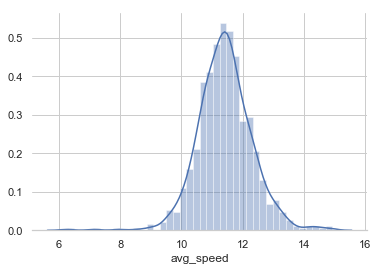

In [366]:
# univariate distribution
sns.set(style = "whitegrid")
ax =sns.distplot(work2way_df.avg_speed)
sns.despine(left=True)

Useful to see the distribution of the 'avg_speed' variable.  Acknowledges but doesn't over play outlier values.

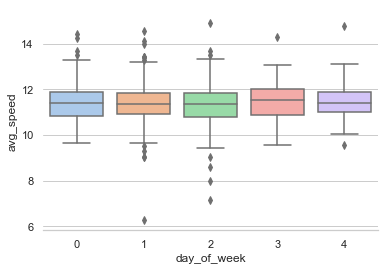

In [367]:
# box plot
sns.set(style = "whitegrid")
ax = sns.boxplot(x=work2way_df.day_of_week,y=work2way_df.avg_speed,data=work2way_df, palette='pastel')  
sns.despine(left=True)

Shows the very small variation in average value.  Doesn't capture the difference in the number of rides per day, but visually compares the spread well.

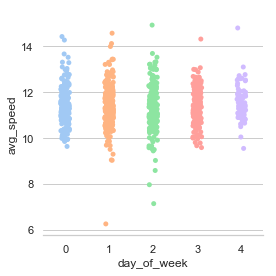

In [368]:
# point plot
sns.set(style = "whitegrid")
ax = sns.catplot(x="day_of_week", y="avg_speed", data=work2way_df,
        height=4, kind='strip', palette="pastel",ci=95,dodge=True)
sns.despine(left=True)

Shows the spread (though not quanitatively), and reflects the difference in the number of, for example, Friday bike days relative to Wednesday bike days.  

## Two continuous variables, three plot

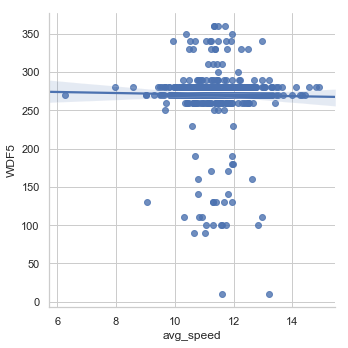

In [383]:
sns.lmplot(x = 'avg_speed', y = 'WDF5', data = work2way_df)

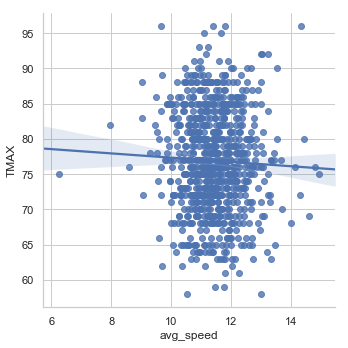

In [369]:
sns.lmplot(x = 'avg_speed', y = 'TMAX', data = work2way_df)

Shows a slight increase in average speed for decreasing temperature.  

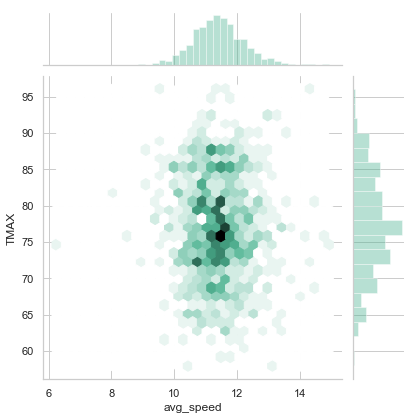

In [370]:
ax = sns.jointplot(work2way_df.avg_speed, work2way_df.TMAX, kind="hex", color="#4CB391")

Shows that both average speed and max temperature have broadly normal distributions and that the lower bound on average speed is somewhat less affected by temperature than the upper bound.

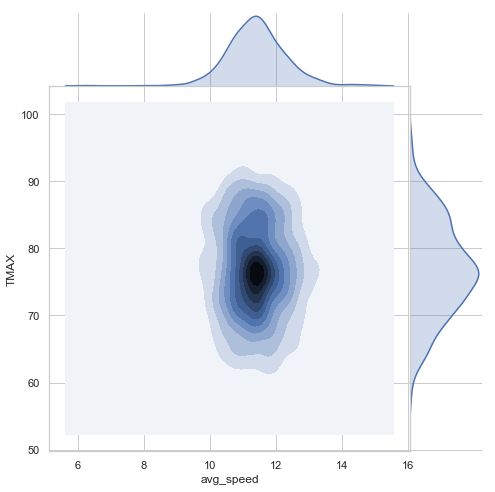

In [371]:
g = sns.jointplot(work2way_df.avg_speed, work2way_df.TMAX, kind="kde", height=7, space=0)

Very similar to above, but highlights the scope of the outlier points.

## One continuous variable, one categorial variable, six plots

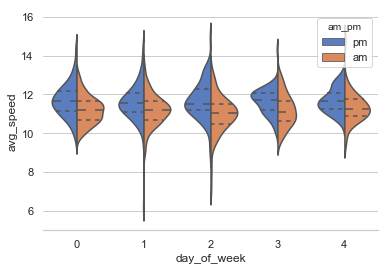

In [372]:
# violin plot
sns.set(style="whitegrid", palette="muted", color_codes=True)
sns.violinplot(x="day_of_week", y="avg_speed", hue="am_pm",
               split=True, inner="quart",

               data=work2way_df)
sns.despine(left=True)

Shows the differences in the shape of the distribution and centering between morning and evening. Does not reflect differences in the number of samples per day.

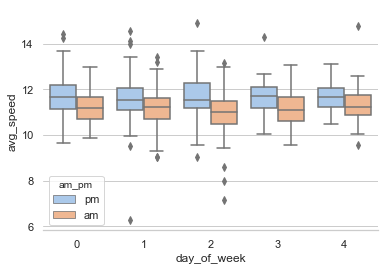

In [373]:
# box plot
sns.set(style = "whitegrid")
ax = sns.boxplot(x=work2way_df.day_of_week,y=work2way_df.avg_speed,data=work2way_df,hue=work2way_df.am_pm, palette='pastel')  
sns.despine(left=True)


/usr/local/lib/python3.6/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


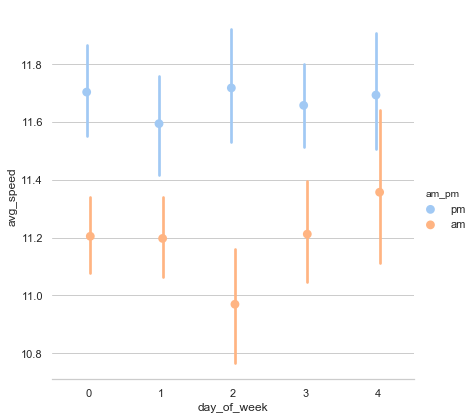

In [374]:
# point plot
sns.set(style = "whitegrid")
g = sns.factorplot(x="day_of_week", y="avg_speed", hue="am_pm", data=work2way_df,
        height=6, kind="point", palette="pastel",ci=95,dodge=True,join=False)
sns.despine(left=True)

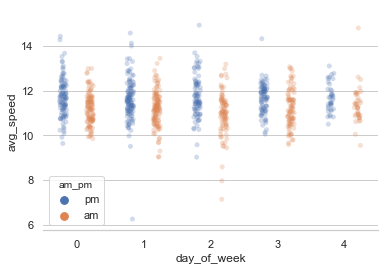

In [375]:
# strip plot
f, ax = plt.subplots()
sns.set(style = "whitegrid")
sns.despine(left=True)
sns.stripplot(x="day_of_week", y="avg_speed",
              data=work2way_df, hue = 'am_pm',dodge=True, jitter=True,
              alpha=.25, zorder=1)

/usr/local/lib/python3.6/site-packages/seaborn/categorical.py:2974: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)


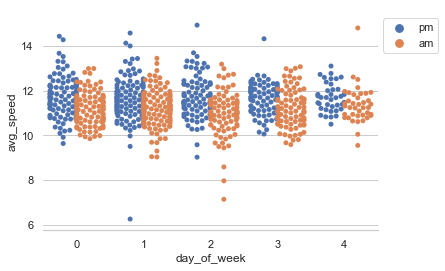

In [376]:
sns.swarmplot(x='day_of_week', y='avg_speed', data=work2way_df, 
              hue='am_pm', split=True,)

sns.despine(left=True)
plt.legend(bbox_to_anchor=(1, 1), loc=2)

Reflects the difference in the number of rides per day and by eye (not quantitatively) the centering and spread of those distributions. 

question: why are the points denser on the edges of the point clouds on days 0-3?

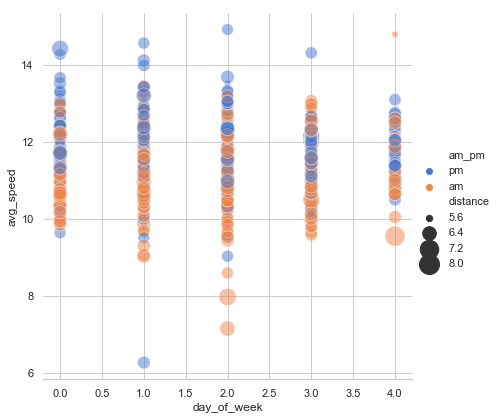

In [377]:
sns.relplot(x='day_of_week', y="avg_speed", hue="am_pm", size="distance",
            sizes=(40, 400), alpha=.5, palette="muted",
            height=6, data=work2way_df)
sns.despine(left=True)

Obscures details about the distribution, but does suggest an overall clustering of evening points at slighly higher average speed than morning points and shows that the distance is quite consistent. 

# Graveyard

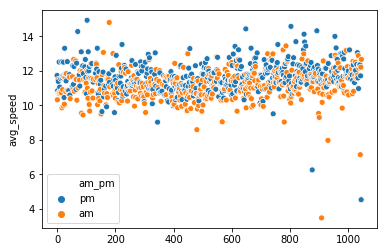

In [269]:
# couldn't figure out the error blocking me from using workout_ts (timestamp)
# as the x variable.  
#
# tried reformatting the time vector: 
# time = work2way_df.workout_ts.apply(lambda x: x.to_datetime())
#
# pyplot didn't throw an error
# ax2 =plt.plot(work2way_df.workout_ts,work2way_df.avg_speed) 

ax =sns.scatterplot(x=work2way_df.index,y=work2way_df.avg_speed, hue = work2way_df.am_pm)


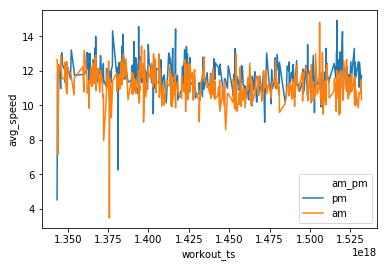

In [262]:
f, ax = plt.subplots()

sns.lineplot(x="workout_ts", y="avg_speed",
             hue="am_pm",
             data=work2way_df)

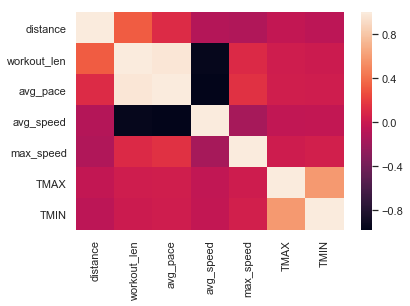

In [378]:
corr = work2way_df[['distance', 'workout_len', 'avg_pace', 'avg_speed', 'max_speed', 'TMAX', 'TMIN']].corr()
sns.heatmap(corr)